In [55]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.estimator as estimator
import src.utils as utils

# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix



np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the graph

In [56]:
n = 100 # number of nodes - 585 similar to c elegans
p = 0  # number of neighbouts to take into account

alpha = -0.3    #  negative 0.003
beta  = -0.3    #  negative the higher the more concentrated will be the edges into a single vertex 0.003
sigma = np.log(1e-3)     # intercept the higher the harder for creating edges 6

threshold   = 0.5
n_iteration = 60 
warm_up     = 20

################################################
params_dict = {
    "n": n,
    "p": p,
    "alpha": alpha,
    "beta": beta,
    "sigma": sigma,
    "threshold": threshold,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}


In [57]:
ut  = utils.GraphUtils()

graphs, spectra = ut.loading_graph_artifacts(params_dict)

# Estimation

In [5]:
g = graphs[-1]
s = spectra[-1]

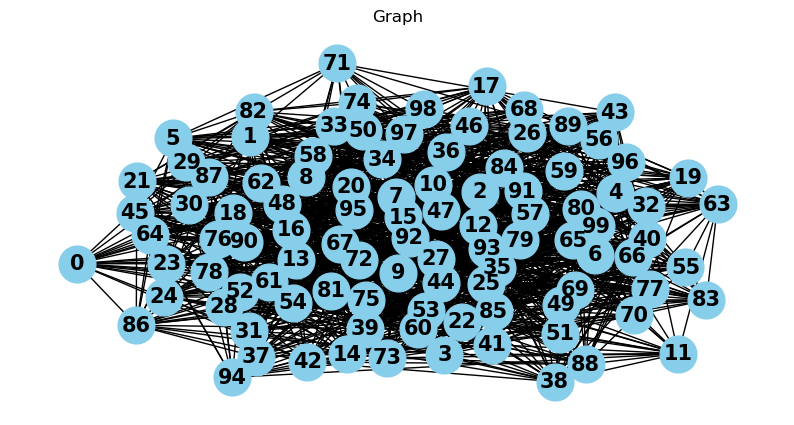

In [6]:
ut.plot_graph_from_adjacency(g, pos=None, title='Graph', size=(10,5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


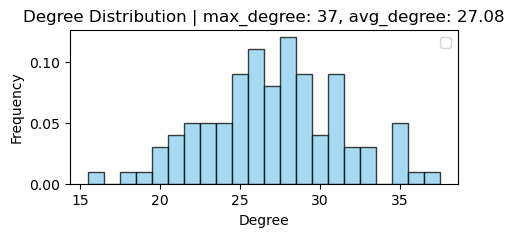

In [7]:
ut.plot_degree_distribution(g, title='Degree Distribution', size=(5,2))

In [8]:
initial_guess = [0.1, 0.9]
est = estimator.MLEGraphModelEstimator(g)

#c_hat, beta_hat, result = est.estimate_parameters(initial_guess=initial_guess)

c_hat, beta_hat = est.estimate_parameters_torch(initial_guess=initial_guess, learning_rate=0.001, max_iter=30)

Current parameters: c=0.10003991425037384, beta=0.8999955654144287, Loss=8415.86328125
Current parameters: c=0.10007982701063156, beta=0.8999911546707153, Loss=8415.86328125
Current parameters: c=0.10011973977088928, beta=0.899986743927002, Loss=8415.86328125
Current parameters: c=0.100159652531147, beta=0.8999823331832886, Loss=8415.86328125
Current parameters: c=0.10019956529140472, beta=0.8999778628349304, Loss=8415.86328125
Current parameters: c=0.10023947805166245, beta=0.8999733924865723, Loss=8415.86328125
Current parameters: c=0.10027939081192017, beta=0.8999689221382141, Loss=8415.86328125
Current parameters: c=0.10031930357217789, beta=0.899964451789856, Loss=8415.86328125
Current parameters: c=0.10035921633243561, beta=0.8999599814414978, Loss=8415.86328125
Current parameters: c=0.10039912909269333, beta=0.8999555110931396, Loss=8415.86328125
Current parameters: c=0.10043904185295105, beta=0.8999510407447815, Loss=8415.86328125
Current parameters: c=0.10047895461320877, beta

In [109]:
print(c_hat,beta_hat)
print(c,beta)
#print(result)

0.18973766267299652 0.2698619067668915
0.001 1


In [110]:
est.likelihood_function([c_hat, beta_hat]), est.likelihood_function([c, beta]), est.likelihood_function([2,0])

(-852.5188167171152, -1271.3680905754281, nan)

## Plot

In [60]:
c_values = np.linspace(0.000001, 2, 100)
beta_values = np.linspace(0.000001, 2, 100)

likelihood = np.empty((len(c_values), len(beta_values)))
for i, ci in enumerate(c_values):
    for j, betaj in enumerate(beta_values):
        likelihood[i, j] = est.likelihood_function([ci, betaj])


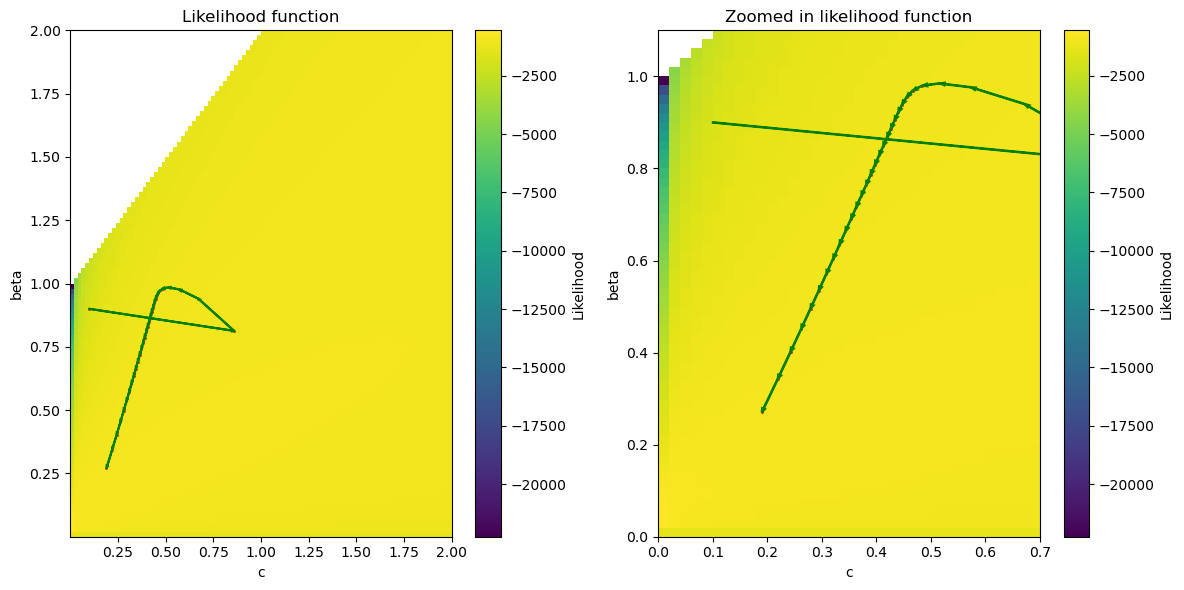

In [111]:
params_history = np.array([initial_guess]+est.params_history)

# Convert the parameters to the corresponding indices in the c_values and beta_values arrays
c_indices = params_history[:, 0]
beta_indices = params_history[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the full heatmap on the first subplot
im = axs[0].imshow(likelihood, origin='lower', extent=[c_values[0], c_values[-1], beta_values[0], beta_values[-1]], aspect='auto')
fig.colorbar(im, ax=axs[0], label='Likelihood')
axs[0].scatter(c_indices, beta_indices, color='red', s=1)  # Change color as needed
for i in range(1, len(c_indices)):
    axs[0].arrow(c_indices[i-1], beta_indices[i-1], c_indices[i]-c_indices[i-1], beta_indices[i]-beta_indices[i-1], 
              shape='full', color='green', lw=1.5, length_includes_head=True, head_width=0.006)
axs[0].set_xlabel('c')
axs[0].set_ylabel('beta')
axs[0].set_title('Likelihood function')

# Plot a zoomed in region on the second subplot
zoom_c_min, zoom_c_max = 0, 0.7  # Adjust these values to zoom in on the desired region
zoom_beta_min, zoom_beta_max = 0, 1.1  # Adjust these values to zoom in on the desired region
im_zoom = axs[1].imshow(likelihood, origin='lower', extent=[c_values[0], c_values[-1], beta_values[0], beta_values[-1]], aspect='auto')
fig.colorbar(im_zoom, ax=axs[1], label='Likelihood')
axs[1].scatter(c_indices, beta_indices, color='red', s=1)  # Change color as needed
for i in range(1, len(c_indices)):
    axs[1].arrow(c_indices[i-1], beta_indices[i-1], c_indices[i]-c_indices[i-1], beta_indices[i]-beta_indices[i-1], 
              shape='full', color='green', lw=1.5, length_includes_head=True, head_width=0.006)
axs[1].set_xlim(zoom_c_min, zoom_c_max)
axs[1].set_ylim(zoom_beta_min, zoom_beta_max)
axs[1].set_xlabel('c')
axs[1].set_ylabel('beta')
axs[1].set_title('Zoomed in likelihood function')

plt.tight_layout()
plt.show()

# Log Reg

In [58]:
g = graphs[-1]
s = spectra[-1]
g


G = nx.Graph(g)

In [59]:
degree_i = np.sum(g, axis=1)  # Degree of each vertex i
degree_j = np.sum(g, axis=0)  # Degree of each vertex j
data = [{
    'i': i,
    'j': j,
    'degree_i': degree_i[i],
    'degree_j': degree_j[j],
    'edge_exists': bool(g[i, j])
} for i in range(g.shape[0]) for j in range(g.shape[1])]

df = pd.DataFrame(data)
df

,i,j,degree_i,degree_j,edge_exists
0,0,0,3.0,6.0,False
1,0,1,3.0,3.0,False
2,0,2,3.0,3.0,False
3,0,3,3.0,3.0,False
4,0,4,3.0,2.0,False
...,...,...,...,...,...
9995,99,95,4.0,7.0,False
9996,99,96,4.0,2.0,False
9997,99,97,4.0,3.0,False
9998,99,98,4.0,4.0,False


In [63]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import networkx as nx

# Assuming 'G' is your graph object (for example, from NetworkX)
G = nx.Graph(g)

edges = list(G.edges())
non_edges = list(nx.non_edges(G))

data = edges + non_edges
labels = [1] * len(edges) + [0] * len(non_edges)

# Feature extraction: degrees of the vertices
features = [(abs(G.degree(i)), abs(G.degree(j))) for i, j in data]

# Logistic Regression Model
model = LogisticRegression()

# Fit the model
model.fit(features, labels)

# Coefficients and intercept
coef_0, coef_1 = model.coef_[0]
intercept = model.intercept_[0]

print(f"coef_0: {coef_0}, coef_1: {coef_1}, intercept: {intercept}")


coef_0: 0.1963521144827451, coef_1: 0.21844863223455993, intercept: -5.163677510626355


In [64]:
i=10
exp_coef = np.dot(features[i],model.coef_[0]) + model.intercept_[0]
y_hat = 1/(1+np.exp(exp_coef))

exp_coef = np.dot(features[10],[alpha, beta]) + sigma
y_true = 1/(1+np.exp(exp_coef))

print(y_hat, y_true)

0.9486033709934932